In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
rhythmroy_sen12flood_flood_detection_dataset_path = kagglehub.dataset_download('rhythmroy/sen12flood-flood-detection-dataset')

print('Data source import complete.')


100%|██████████| 12.2G/12.2G [08:40<00:00, 25.2MB/s]

Extracting files...


Data source import complete.


# SEN12FLOOD - EDA

References and resources
* https://www.int-arch-photogramm-remote-sens-spatial-inf-sci.net/XLIII-B2-2020/1343/2020/isprs-archives-XLIII-B2-2020-1343-2020.pdf
* https://arxiv.org/pdf/2006.10027v1.pdf#page=2

## Imports

In [7]:
from google.colab import files
files.upload()  # This will prompt you to upload the file

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"innitsic","key":"07f2a57210f2ad149b1fa3ddfaf328c7"}'}

In [5]:
!pip install -q kaggle

In [8]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d rhythmroy/sen12flood-flood-detection-dataset

Dataset URL: https://www.kaggle.com/datasets/rhythmroy/sen12flood-flood-detection-dataset
License(s): other
sen12flood-flood-detection-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
!unzip sen12flood-flood-detection-dataset.zip -d /content/sen12flood

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: /content/sen12flood/SEN12FLOOD/27/S1B_IW_GRDH_1SDV_20190327T024547_20190327T024609_015534_01D1E4_D67E_corrected_VH.tif  
  inflating: /content/sen12flood/SEN12FLOOD/27/S1B_IW_GRDH_1SDV_20190327T024547_20190327T024609_015534_01D1E4_D67E_corrected_VV.tif  
  inflating: /content/sen12flood/SEN12FLOOD/27/S1B_IW_GRDH_1SDV_20190408T024547_20190408T024612_015709_01D7A5_5DB9_corrected_VH.tif  
  inflating: /content/sen12flood/SEN12FLOOD/27/S1B_IW_GRDH_1SDV_20190408T024547_20190408T024612_015709_01D7A5_5DB9_corrected_VV.tif  
  inflating: /content/sen12flood/SEN12FLOOD/27/S1B_IW_GRDH_1SDV_20190412T145023_20190412T145048_015775_01D9BD_4A6C_corrected_VH.tif  
  inflating: /content/sen12flood/SEN12FLOOD/27/S1B_IW_GRDH_1SDV_20190412T145023_20190412T145048_015775_01D9BD_4A6C_corrected_VV.tif  
  inflating: /content/sen12flood/SEN12FLOOD/27/S1B_IW_GRDH_1SDV_20190420T024547_20190420T024612_015884_01DD6F_1983_cor

In [16]:
%pip install rioxarray --quiet --no-cache-dir

from pathlib import Path
import json

import numpy as np
import xarray as xr
import rioxarray as xrio

import matplotlib.pyplot as plt

from shapely.geometry import shape
import pandas as pd
import geopandas as gpd


# imports required for the LeeFilter (Sentinel 1)
from scipy.ndimage import variance
from scipy.ndimage import uniform_filter


# Files Structure

In [17]:
from pathlib import Path

# Define the root path
root = Path('/content/sen12flood/SEN12FLOOD/')

# Check if the root directory exists
if root.exists() and root.is_dir():
    print(f"Root directory found at: {root}")

    # List files and folders in the root directory
    files = [f for f in root.iterdir() if not f.is_dir()]
    folders = [f for f in root.iterdir() if f.is_dir()]

    print("\nFiles in the root directory:")
    for file in files:
        print(file.name)

    print("\nFolders in the root directory:")
    for folder in folders:
        print(folder.name)
else:
    print(f"Root directory not found at: {root}")

Root directory found at: /content/sen12flood/SEN12FLOOD

Files in the root directory:
new.tif
new.tif.aux.xml
S2list.json
S1list.json
.directory

Folders in the root directory:
0253
0298
0066
0045
22
57
0212
0181
0182
8
0249
0257
0232
0043
0101
67
0201
0097
0069
0281
0107
53
0130
0075
0158
0118
0318
66
0223
0220
10
42
0169
39
0279
16
0282
0102
0160
0300
19
0244
0262
48
0
0065
51
0221
0030
46
0149
0196
62
0287
0111
0316
38
0135
0207
0174
0044
0103
0104
0073
0273
0025
32
0096
0161
5
0229
0321
0046
0086
0313
0288
3
0024
0323
0304
11
0084
0199
0035
0070
44
0082
0276
0146
34
0123
0241
0216
0167
0311
0037
0013
0150
0187
0266
0165
24
0093
0238
0303
0055
0140
0144
47
0294
0004
0329
0120
43
0275
17
0168
0259
0246
0088
54
0324
0031
0240
6
0333
4
18
0277
0079
0094
0227
28
0131
0157
0243
37
0245
0296
0274
0098
0068
0085
0166
0217
0271
0170
0286
0230
0089
0213
0278
0133
15
26
0134
0162
0071
25
0310
31
0053
27
0143
55
0306
0178
0077
0109
0023
1
0042
2
0325
0258
0047
0250
0309
0210
0326
0067
0254
009

In [18]:
json_files = [f for f in files if f.suffix == '.json']
print("\nJSON files found:")
for json_file in json_files:
    print(json_file.name)



JSON files found:
S2list.json
S1list.json


In [19]:
import json

# Define file paths with correct names
s2file = root / "S2list.json"
s1file = root / "S1list.json"

# Check if files exist before opening
if s2file.exists() and s1file.exists():
    with s2file.open("r") as f:
        s2json = json.load(f)

    with s1file.open("r") as f:
        s1json = json.load(f)

    # Grab the first item safely
    s2key, s2item = next(iter(s2json.items()))
    s1key, s1item = next(iter(s1json.items()))

    print(s2key, s1key)
else:
    print("One or both JSON files are missing!")


0063 0063


In [20]:
# they refer to the same item (folder 0063), so let's comapare their contents
s2item

{'1': {'date': '2019-02-04',
  'FLOODING': False,
  'FULL-DATA-COVERAGE': True,
  'filename': 'S2_2019-02-04'},
 'count': 1,
 'folder': '0063',
 'geo': {'type': 'Polygon',
  'coordinates': [[[28.29722, -15.382762],
    [28.297507, -15.429039],
    [28.345216, -15.428755],
    [28.344918, -15.382479],
    [28.29722, -15.382762]]]}}

In [21]:
s1item

{'count': 2,
 '2': {'date': '2019-02-09',
  'FLOODING': False,
  'orbit': 'ASCENDING',
  'filename': 'S1B_IW_GRDH_1SDV_20190209T163240_20190209T163305_014871_01BC1F_7E74'},
 '1': {'date': '2019-01-28',
  'FLOODING': False,
  'orbit': 'ASCENDING',
  'filename': 'S1B_IW_GRDH_1SDV_20190128T163241_20190128T163306_014696_01B65E_5615'},
 'folder': '0063',
 'geo': {'type': 'Polygon',
  'coordinates': [[[28.29722, -15.382762],
    [28.297507, -15.429039],
    [28.345216, -15.428755],
    [28.344918, -15.382479],
    [28.29722, -15.382762]]]},
 'urls': ['https://datapool.asf.alaska.edu/GRD_HD/SB/S1B_IW_GRDH_1SDV_20190209T163240_20190209T163305_014871_01BC1F_7E74.zip',
  'https://datapool.asf.alaska.edu/GRD_HD/SB/S1B_IW_GRDH_1SDV_20190128T163241_20190128T163306_014696_01B65E_5615.zip']}

In this metadata we have the acquire date, the folder and the polygon in WGS84 with the patch footprint.  In the s1json file we have `count=2`, indicating there are two images covering this area. Their names and acquision dates are indicated.

Let's have a look inside this folder.

In [22]:
folder = root/s2key
list(folder.iterdir())

[PosixPath('/content/sen12flood/SEN12FLOOD/0063/S2_2019-02-04_B08.tif'),
 PosixPath('/content/sen12flood/SEN12FLOOD/0063/S2_2019-02-04_B11.tif'),
 PosixPath('/content/sen12flood/SEN12FLOOD/0063/infosS2.json'),
 PosixPath('/content/sen12flood/SEN12FLOOD/0063/S2_2019-02-04_B03.tif'),
 PosixPath('/content/sen12flood/SEN12FLOOD/0063/S2_2019-02-04_B06.tif'),
 PosixPath('/content/sen12flood/SEN12FLOOD/0063/S1B_IW_GRDH_1SDV_20190209T163240_20190209T163305_014871_01BC1F_7E74_corrected_VV.tif'),
 PosixPath('/content/sen12flood/SEN12FLOOD/0063/S2_2019-02-04_B04.tif'),
 PosixPath('/content/sen12flood/SEN12FLOOD/0063/S2_2019-02-04_B07.tif'),
 PosixPath('/content/sen12flood/SEN12FLOOD/0063/S1B_IW_GRDH_1SDV_20190128T163241_20190128T163306_014696_01B65E_5615_corrected_VH.tif'),
 PosixPath('/content/sen12flood/SEN12FLOOD/0063/S2_2019-02-04_B12.tif'),
 PosixPath('/content/sen12flood/SEN12FLOOD/0063/S2_2019-02-04_B02.tif'),
 PosixPath('/content/sen12flood/SEN12FLOOD/0063/S2_2019-02-04_B05.tif'),
 PosixP

* For the S2 we have all spactral bands from B01 (Aerosol) to B12 (SWIR)
* whilst for S1 we have the two indicated images with VV and VH polarizations, and the values correspond to the backscatter

In this folder we still have a final file called `infosS2.json`. Let's take a look at it.

In [23]:
json.load(list(folder.glob("infosS2.json"))[0].open())

{'count': 1,
 '1': {'date': '2019-02-04', 'FULL-DATA-COVERAGE': True, 'FLOODING': False},
 'geo': {'type': 'Polygon',
  'coordinates': [[[28.29722, -15.382762],
    [28.297507, -15.429039],
    [28.345216, -15.428755],
    [28.344918, -15.382479],
    [28.29722, -15.382762]]]}}

That's basically the same info as before.

# Data Visualization - Load function

In this section, we are going to visualize the patches in the first folder we just digged in.

In [24]:
# First, let's create a function to load the desired bands into an xarray Dataset
def load_img(folder, filename, bands=['B04', 'B03', 'B02']):

    # get the files paths
    files = [folder/(filename+f'_{b}.tif') for b in bands]

    # Open each file with rioxarray and save them to a dictionary
    # using the band as key
    files_dict = {b: xrio.open_rasterio(f).squeeze() for b, f in zip(bands, files)}

    # put the files into a dataset
    ds = xr.Dataset(files_dict)

    # convert to an DataArray creating a band dimension
    return ds.to_array(dim='band')


# Data Viz - Sentinel 2

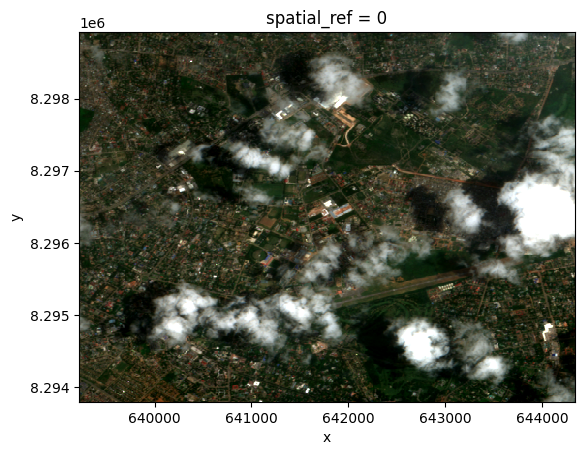

In [25]:
s2 = load_img (
    folder = root/s2item['folder'],
    filename=s2item['1']['filename']
)

s2.plot.imshow(rgb='band', robust=True)

# Data Viz - Sentinel 1

For the Sentinel 1 patch, the visualization process is a little more tricky. We first have to remove some of the noise (using Lee Filter) and then create a false RGB. Let's declare these two functions:

In [26]:
import warnings

# Filter out the specific RuntimeWarning
warnings.filterwarnings("ignore", message="invalid value encountered in log", category=RuntimeWarning)

def lee_filter(da: xr.DataArray, size: int):
    """
    Apply lee filter to a DataArray specified window size.
    Adapted from https://stackoverflow.com/questions/39785970/speckle-lee-filter-in-python

    """
    # get the kernel, considering the number of bands

    if "band" in da.dims:
        da = da.transpose("band", "y", "x")
        kernel = (1, size, size)
    else:
        kernel = (size, size)

    # create a mask
    mask = np.isnan(da.values)

    img = np.nan_to_num(da.values, nan=np.nanmean(da.values))

    img_mean = uniform_filter(img, kernel)
    img_sqr_mean = uniform_filter(img**2, kernel)
    img_variance = img_sqr_mean - img_mean**2

    overall_variance = variance(img)

    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)

    # write the mask
    img_output[mask] = np.nan

    return img_output


def false_color(vv, vh):
    """
    Receives a VV and VH arrays and returns a 3D RGB array, with a `color_band` as dimension
    https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-1/sar_false_color_visualization/
    """

    c1 = 10e-4
    c2 = 0.01
    c3 = 0.02
    c4 = 0.03
    c5 = 0.045
    c6 = 0.05
    c7 = 0.9
    c8 = 0.25

    red = c4 + np.log(c1 - np.log(c6 / (c3 + 2 * vv)))
    green = c6 + np.exp(c8 * (np.log(c2 + 2 * vv) + np.log(c3 + 5 * vh)))
    blue = 1 - np.log(c6 / (c5 - c7 * vv))

    rgb_xr = xr.Dataset({"red": red, "green": green, "blue": blue})
    return rgb_xr.to_array(dim="color_band").fillna(0).clip(0, 1)

In [27]:
# Let's load both s1 patches into a dictionary
s1imgs = {key: load_img(
    folder = root/s1item['folder'],
    filename=s1item[key]['filename'] + '_corrected',
    bands=['VV', 'VH']
) for key in ['1', '2']}

# Let's filter the noise speckle using Lee Filter.
# and create a RGB representation
for key in ['1', '2']:
    s1imgs[key].data = lee_filter(s1imgs[key], 7)
    s1imgs[key] = false_color(s1imgs[key].sel(band='VV'), s1imgs[key].sel(band='VH'))

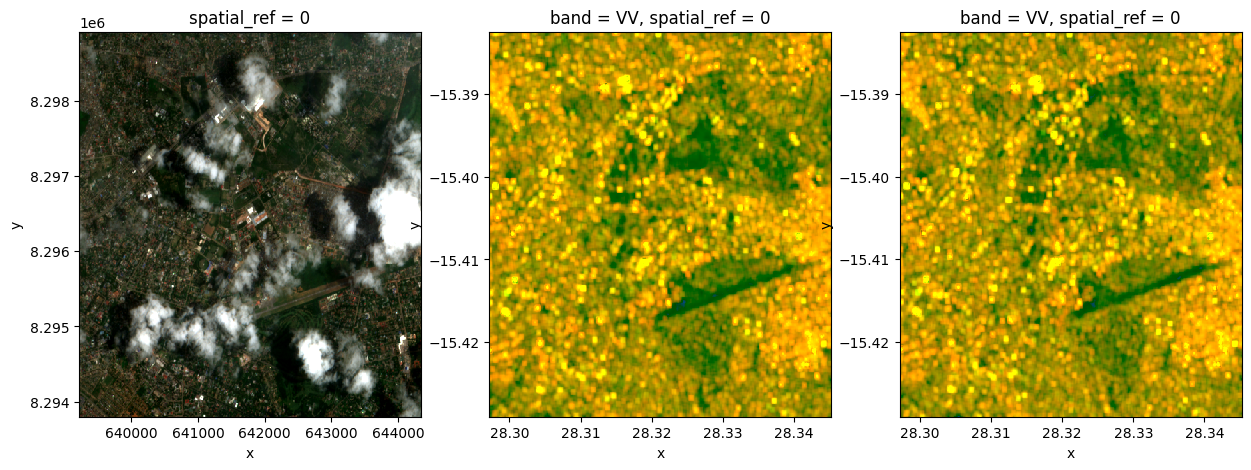

In [28]:
# let's plot the patches together
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# plot the s2image
s2.plot.imshow(ax=axs[0], rgb='band', robust=True)

# plot the s1images
for key in ['1', '2']:
    s1imgs[key].plot.imshow(ax=axs[int(key)], rgb='color_band')


# Global Coverage

Now that we've taken a look at one patch, let's see how they are spread over the globe.
For that, we are going to load the json into a GeoDataFrame (geopandas).

In [29]:
# Convert the `geo` tag in shapely Polygons
geoms = {key: shape(item['geo']) for key, item in s2json.items()}

# create a GeoDataFrame with the patches and the geometries
gdf = gpd.GeoDataFrame({'patch': geoms.keys(), 'footprint': geoms.values()})

# create the centroid to be the geometry column of the DataFrame
gdf['center'] = gpd.GeoSeries(gdf['footprint']).centroid
gdf.set_geometry('center', inplace=True)

In [30]:
# Additionally, let's load the countries to serve as basemap
# The geojson for this and many other layers are freely available from `geojson.xyz` webseite.
globe = gpd.read_file('https://d2ad6b4ur7yvpq.cloudfront.net/naturalearth-3.3.0/ne_50m_admin_0_countries.geojson')

<Axes: >

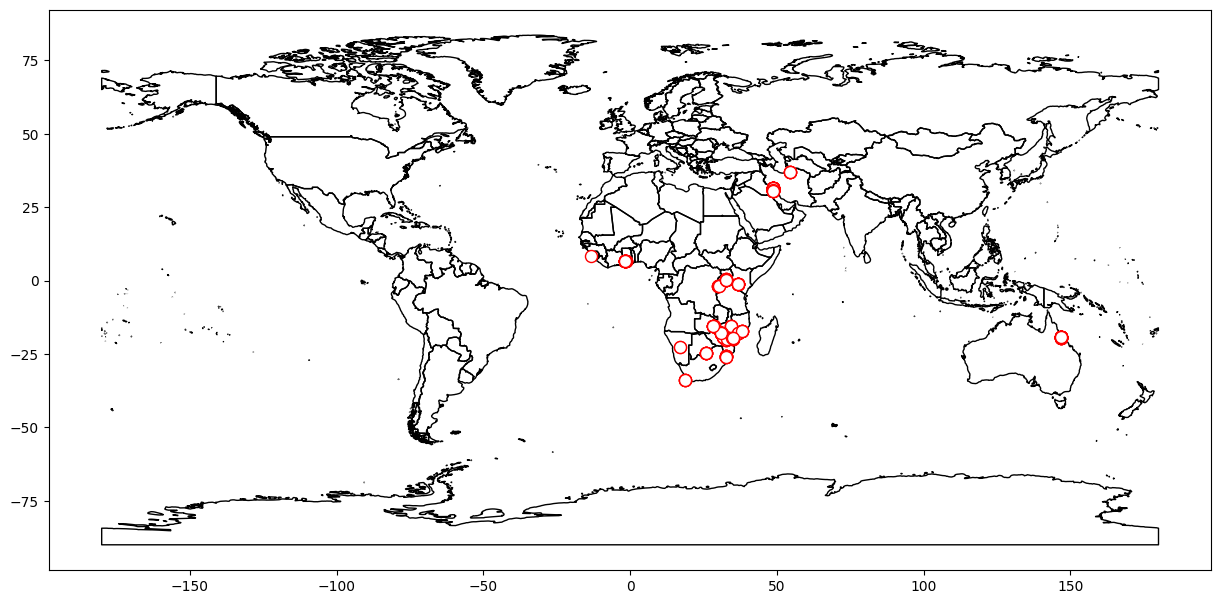

In [31]:
ax = globe.plot(facecolor='none', figsize=(15, 10))
gdf.plot(ax=ax, color='red', facecolor='white', markersize=75)

# Flood Event

To Finish this EDA, let's take a look at a flood event. For that, let's take a patch with that has flooded images.

## Helper function to extract images

In [32]:
def extract_imgs(data_item: dict) -> pd.DataFrame:
    """Extract all the images in a specific patch (location)"""

    # get attributes from the item
    folder = data_item['folder']
    count = data_item['count']

    if 'urls' in data_item:
        del data_item['urls']

    # create a dataframe with the images
    df = pd.DataFrame(data_item).T
    df = df.drop(index=['folder', 'count', 'geo'], columns=['type', 'coordinates'])

    # save attributes
    df['folder'] = folder
    df['count'] = count

    # at last, drop missing files
    return df.dropna()


def plot_s2patch(patch: str, s2data: pd.DataFrame, cols: int = 3):

    # get a df with the images to be plotted
    df = s2data.query(f'folder == "{patch}"').sort_values('date').reset_index(drop=True)
    n = len(df)

    # create a plotting area
    rows = n//cols + (1 if n%cols > 0 else 0)

    fig, axs = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
    axs = axs.reshape(-1)

    for i, row in df.iterrows():
        ax=axs[i]

        s2img = load_img (
            folder = root/row['folder'],
            filename=row['filename']
        ) / 1e4

        s2img.plot.imshow(rgb='band', vmin=0, vmax=0.3, ax=ax)

        title = '(flood)' if row['FLOODING'] else '(no flood)'
        title = row['date'] + ' ' + title
        ax.set_title(title)



def plot_s1patch(patch: str, s1data: pd.DataFrame, cols: int = 4):

    # get a df with the images to be plotted
    df = s1data.query(f'folder == "{patch}"').sort_values('date').reset_index(drop=True)
    n = len(df)

    # create a plotting area
    rows = n//cols + (1 if n%cols > 0 else 0)

    fig, axs = plt.subplots(rows, cols, figsize=(cols * 7, rows * 7))
    axs = axs.reshape(-1)

    for i, row in df.iterrows():
        ax=axs[i]

        s1img = load_img (
            folder = root/row['folder'],
            filename=row['filename'] + '_corrected',
            bands=['VV', 'VH']
        )

        s1img.data = lee_filter(s1img, 7)
        s1img = false_color(s1img.sel(band='VV'), s1img.sel(band='VH'))

        s1img.plot.imshow(rgb='color_band', ax=ax)

        title = '(flood)' if row['FLOODING'] else '(no flood)'
        title = row['date'] + ' ' + title
        title = title + '\n' + row['orbit']
        ax.set_title(title)

## Load images list into dataframes

In [33]:
# Organize the data in DataFrames for the s2 and s1 images
s2data = pd.concat([extract_imgs(item) for item in s2json.values()], axis=0)
s1data = pd.concat([extract_imgs(item) for item in s1json.values()], axis=0)

s2patches = s2data.groupby('folder').max()
s1patches = s1data.groupby('folder').max()

patches = s2patches.join(s1patches, lsuffix='_S2', rsuffix='_S1')

In [34]:
patches.query('FLOODING_S2 == True')

,date_S2,FLOODING_S2,FULL-DATA-COVERAGE,filename_S2,count_S2,date_S1,FLOODING_S1,orbit,filename_S1,count_S1
folder,,,,,,,,,,
0,2019-04-21,True,True,S2_2019-04-21,9,2019-04-19,True,DESCENDING,S1B_IW_GRDH_1SDV_20190419T160654_20190419T1607...,20
0137,2019-04-09,True,True,S2_2019-04-09,6,2019-04-07,True,DESCENDING,S1B_IW_GRDH_1SDV_20190407T160813_20190407T1608...,12
0138,2019-04-09,True,True,S2_2019-04-09,6,2019-04-07,True,DESCENDING,S1B_IW_GRDH_1SDV_20190407T160748_20190407T1608...,10
0139,2019-04-09,True,True,S2_2019-04-09,6,2019-04-07,True,DESCENDING,S1B_IW_GRDH_1SDV_20190407T160748_20190407T1608...,10
0140,2019-04-21,True,True,S2_2019-04-21,9,2019-04-19,True,DESCENDING,S1B_IW_GRDH_1SDV_20190419T160654_20190419T1607...,28
...,...,...,...,...,...,...,...,...,...,...
61,2019-04-24,True,True,S2_2019-04-24,9,2019-04-17,True,DESCENDING,S1B_IW_GRDH_1SDV_20190417T162320_20190417T1623...,15
62,2019-04-23,True,True,S2_2019-04-23,9,2019-04-21,False,DESCENDING,S1B_IW_GRDH_1SDV_20190420T024612_20190420T0246...,17
63,2019-04-23,True,True,S2_2019-04-23,9,2019-04-20,False,DESCENDING,S1B_IW_GRDH_1SDV_20190420T024612_20190420T0246...,14


In [35]:
plot_s2patch('65', s2data)

Output hidden; open in https://colab.research.google.com to view.

In [36]:
plot_s1patch('65', s1data)

Output hidden; open in https://colab.research.google.com to view.

I doubled checked this dataset and the code many times. This location (65) seems to have an issue with the labels.

In [37]:
s1data.to_csv('s1data.csv')
s2data.to_csv('s2data.csv')

In [38]:
patches.to_csv('patches.csv')

In [39]:
from google.colab import files
files.download('s1data.csv')
files.download('s2data.csv')
files.download('patches.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [40]:
!pip install rioxarray xarray tensorflow keras matplotlib numpy pandas scikit-learn

In [41]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import xarray as xr
import rioxarray as xrio
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split

In [42]:
patches_df = pd.read_csv("patches.csv")
s1_df = pd.read_csv("s1data.csv")
s2_df = pd.read_csv("s2data.csv")

In [62]:
from pathlib import Path

def load_img(folder, filename, bands=['VV', 'VH']):
    # Convert folder to Path
    folder = Path(folder)

    # Create file paths
    files = [folder / f"{filename}_{b}.tif" for b in bands]

    # Check file existence
    missing_files = [f for f in files if not f.exists()]
    if missing_files:
        print(f"Missing files: {missing_files}")
        return None

    # Load files
    files_dict = {b: xrio.open_rasterio(str(f)).squeeze() for b, f in zip(bands, files)}
    return xr.Dataset(files_dict).to_array(dim='band')

def preprocess_image(img):
    img = img.to_numpy()
    img = np.nan_to_num(img)  # Replace NaN with 0
    img = (img - np.min(img)) / (np.max(img) - np.min(img))  # Normalize
    return img

# Create Dataset
X, Y = [], []
for _, row in patches_df.iterrows():
    s1_img = load_img(row['folder'], row['filename_S1'])
    s2_img = load_img(row['folder'], row['filename_S2'], bands=['B04', 'B03', 'B02'])

    # Skip if either image failed to load
    if s1_img is None or s2_img is None:
        continue

    s1_img = preprocess_image(s1_img)
    s2_img = preprocess_image(s2_img)

    combined_img = np.concatenate([s1_img, s2_img], axis=0)  # Stack Sentinel-1 & 2

    X.append(combined_img)
    Y.append(int(row['FLOODING_S1'] or row['FLOODING_S2']))  # Label: Flood or Not

X = np.array(X)
Y = np.array(Y)

TypeError: expected str, bytes or os.PathLike object, not int

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=X_train.shape[1:]),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary Classification (Flood/No Flood)
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, Y_train, epochs=10, validation_data=(X_test, Y_test), batch_size=16)

In [ ]:
loss, acc = model.evaluate(X_test, Y_test)
print(f"Test Accuracy: {acc * 100:.2f}%")

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [3]:
!git config --global user.name "Ghita-Labzar"
!git config --global user.email "labzarghitaa@gmail.com"


In [4]:
!git clone https://github.com/Nouhailachakouk/Flood-detection.git
%cd Flood-detection


Cloning into 'Flood-detection'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 21 (delta 5), reused 20 (delta 4), pack-reused 0 (from 0)
Receiving objects: 100% (21/21), 173.86 KiB | 937.00 KiB/s, done.
Resolving deltas: 100% (5/5), done.
/content/Flood-detection


In [11]:
!ls /content/drive/MyDrive




'002 - Les chaînes de caractères - Séance 1.mp4.gdrive'
'1- Inventeur du premier portable.gdoc'
'20. Kim Jung Ju, Kim Jae Rim - JEONGSEO BULAN.mp3'
 86B4F9CD-0CC1-4D57-B65B-86D6DD3C629F.jpeg
'Bac 2021.gsheet'
'Briefing 05 12 2024.gdoc'
 C4344999-702E-4A9E-939B-8BFA87BBAD77.jpeg
'Cahier de charge.gdoc'
'CamScanner 04-03-2024 15.39.pdf'
 Classiques.gdoc
 Classroom
'Colab Notebooks'
'Compte rendu POO TD_TP1.gdoc'
'Compte rendu serie 7-8.gdoc'
'Compte Rendu TP5 Ghita Labzar version word.docx'
 compte_rendu_tp_ghita_labzar.gdoc
 Compte_rendu_trotinette.gdoc
 Curriculum
 CV_Ghita_Labzar.gdoc
 Demo_MicroEJ_SSE.gdoc
'Document sans titre (10).gdoc'
'Document sans titre (11).gdoc'
'Document sans titre (12).gdoc'
'Document sans titre (13).gdoc'
'Document sans titre (14).gdoc'
'Document sans titre (15).gdoc'
'Document sans titre (16).gdoc'
'Document sans titre (17).gdoc'
'Document sans titre (18).gdoc'
'Document sans titre (19).gdoc'
'Document sans titre (1).gdoc'
'Document sans titre (20).gdoc